https://docs.google.com/presentation/d/1ji4JgDxm4zp_AnsC_NIpZkusBhD5DtUV4iU9gj9i_Z4/edit#slide=id.g6021744a7c_1_163

# Maps

In [1]:
from reduction import *
from utils import *

data_maps = {1: image_reduction(1), 2: image_reduction(2)}

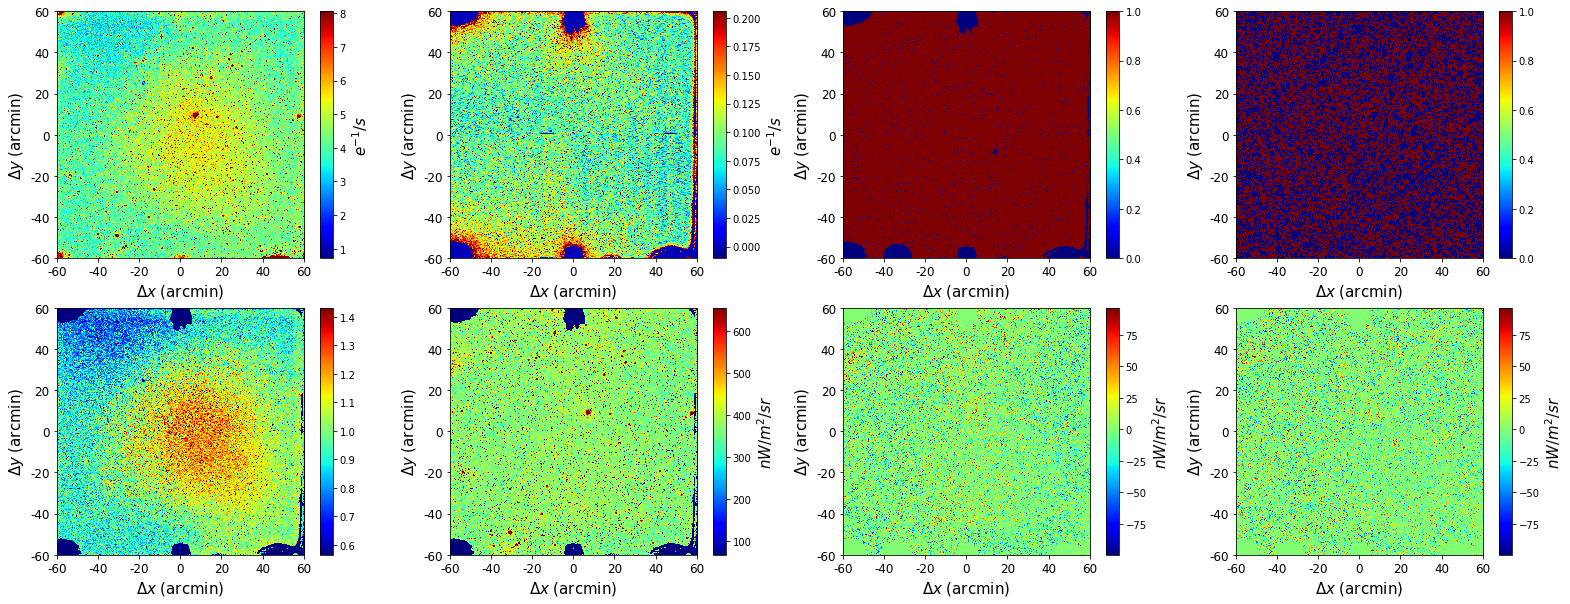

In [2]:
pixticks = np.linspace(0,1023,7)
pixtick_labels = ['-60', '-40', '-20', '0', '20', '40', '60']

for ifield in [4,5,6,7,8]:
    for inst in [1,2]:
        filt_order = filt_order_dict[inst]
        apf2eps = cal_factor_dict['apf2eps'][inst]
        apf2nWpm2psr = cal_factor_dict['apf2nWpm2psr'][inst][ifield]
        rawmap, DCmap, mask_inst, mapin, cbmap, strmask, FF\
        = load_processed_images(data_maps, [(inst,ifield,'rawmap'),
                                            (inst,ifield,'DCmap'),
                                           (inst,ifield,'mask_inst'),
                                           (inst,ifield,'map'),
                                           (inst,ifield,'cbmap'),
                                           (inst,ifield,'strmask'),
                                           (inst,ifield,'FF')],
                               rotate_TM2=True)
        plt.close()
        fig, ax = plt.subplots(2, 4, figsize = (27,10))
        axi = ax[0][0]
        p = imageclip(rawmap*apf2eps, ax=axi, return_objects=True)
        p['cbar'].ax.set_ylabel('$e^{-1}/s$', rotation=90, fontsize=15)
        axi.set_xticks(pixticks)
        axi.set_xticklabels(pixtick_labels, fontsize=12)
        axi.set_xlabel(r"$\Delta x$ (arcmin)", fontsize=15)
        axi.set_yticks(pixticks)
        axi.set_yticklabels(pixtick_labels, fontsize=12)
        axi.set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)
        
        axi = ax[0][1]
        p = imageclip(DCmap*apf2eps, ax=axi, return_objects=True)
        p['cbar'].ax.set_ylabel('$e^{-1}/s$', rotation=90, fontsize=15)
        axi.set_xticks(pixticks)
        axi.set_xticklabels(pixtick_labels, fontsize=12)
        axi.set_xlabel(r"$\Delta x$ (arcmin)", fontsize=15)
        axi.set_yticks(pixticks)
        axi.set_yticklabels(pixtick_labels, fontsize=12)
        axi.set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)

        axi = ax[0][2]
        p = imageclip(mask_inst, ax=axi, return_objects=True)
        axi.set_xticks(pixticks)
        axi.set_xticklabels(pixtick_labels, fontsize=12)
        axi.set_xlabel(r"$\Delta x$ (arcmin)", fontsize=15)
        axi.set_yticks(pixticks)
        axi.set_yticklabels(pixtick_labels, fontsize=12)
        axi.set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)
        
        axi = ax[0][3]
        p = imageclip(strmask, ax=axi, return_objects=True)
        axi.set_xticks(pixticks)
        axi.set_xticklabels(pixtick_labels, fontsize=12)
        axi.set_xlabel(r"$\Delta x$ (arcmin)", fontsize=15)
        axi.set_yticks(pixticks)
        axi.set_yticklabels(pixtick_labels, fontsize=12)
        axi.set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)

        axi = ax[1][0]
        p = imageclip(FF, ax=axi, return_objects=True)
        axi.set_xticks(pixticks)
        axi.set_xticklabels(pixtick_labels, fontsize=12)
        axi.set_xlabel(r"$\Delta x$ (arcmin)", fontsize=15)
        axi.set_yticks(pixticks)
        axi.set_yticklabels(pixtick_labels, fontsize=12)
        axi.set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)
        
        axi = ax[1][2]
        p = imageclip(cbmap*mask_inst*strmask, ax=axi, return_objects=True)
        p['cbar'].ax.set_ylabel('$nW/m^2/sr$', rotation=90, fontsize=15)
        axi.set_xticks(pixticks)
        axi.set_xticklabels(pixtick_labels, fontsize=12)
        axi.set_xlabel(r"$\Delta x$ (arcmin)", fontsize=15)
        axi.set_yticks(pixticks)
        axi.set_yticklabels(pixtick_labels, fontsize=12)
        axi.set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)

        axi = ax[1][3]
        filtmap = image_poly_filter(cbmap, strmask*mask_inst, degree=filt_order)
        p = imageclip(filtmap*mask_inst*strmask, ax=axi, 
                      vmin=p['vmin'], vmax=p['vmax'],return_objects=True)
        p['cbar'].ax.set_ylabel('$nW/m^2/sr$', rotation=90, fontsize=15)
        axi.set_xticks(pixticks)
        axi.set_xticklabels(pixtick_labels, fontsize=12)
        axi.set_xlabel(r"$\Delta x$ (arcmin)", fontsize=15)
        axi.set_yticks(pixticks)
        axi.set_yticklabels(pixtick_labels, fontsize=12)
        axi.set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)

        axi = ax[1][1]
        meanmap = np.mean(mapin[mask_inst*strmask==1])*apf2nWpm2psr
        p = imageclip(mapin*apf2nWpm2psr, ax=axi,
                      vmin=3*p['vmin']+meanmap, vmax=3*p['vmax']+meanmap,return_objects=True)
        p['cbar'].ax.set_ylabel('$nW/m^2/sr$', rotation=90, fontsize=15)
        axi.set_xticks(pixticks)
        axi.set_xticklabels(pixtick_labels, fontsize=12)
        axi.set_xlabel(r"$\Delta x$ (arcmin)", fontsize=15)
        axi.set_yticks(pixticks)
        axi.set_yticklabels(pixtick_labels, fontsize=12)
        axi.set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)

        plt.savefig('plots/paperfig/maps_TM%d_%s.pdf'%(inst, fieldnamedict[ifield]),
                    dpi = 200, bbox_inches='tight')

Text(0, 0.5, '$\\Delta y$ (arcmin)')

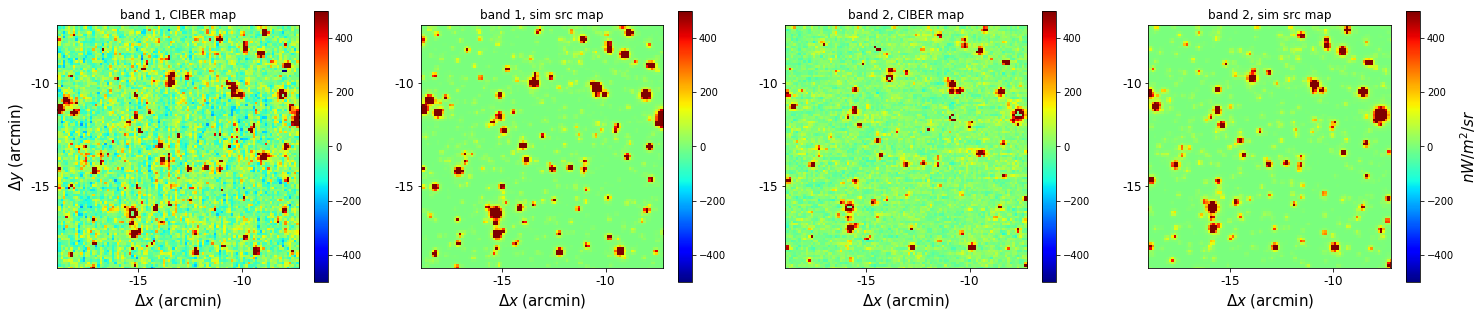

In [9]:
fig, ax = plt.subplots(1, 4, figsize = (25,5))

pixticks1 = np.linspace(0,511.5,13)
pixtick_labels1 = ['-60', '-55', '-50', '-45', '-40', '-35', 
                  '-30', '-25', '-20', '-15', '-10', '-5', '0']

ifield = 8
for inst in [1,2]:
    mask_inst, cbmap, psmap\
    = load_processed_images(data_maps, [(inst,ifield,'mask_inst'),
                                       (inst,ifield,'cbmap'),
                                       (inst,ifield,'psmap')],
                           rotate_TM2=True)
    
    axi = ax[inst*2-2]
    p = imageclip(cbmap*mask_inst, vmin=-500, vmax=500, ax=axi, return_objects=True)
    axi.set_xticks(pixticks1)
    axi.set_xticklabels(pixtick_labels1, fontsize=12)
    axi.set_xlabel(r"$\Delta x$ (arcmin)", fontsize=15)
    axi.set_yticks(pixticks1)
    axi.set_yticklabels(pixtick_labels1, fontsize=12)
    axi.set_title('band %d, CIBER map'%inst)
    axi.set_xlim([350,450])
    axi.set_ylim([350,450])
    

    axi = ax[inst*2-1]
    p = imageclip(psmap, vmin=-500, vmax=500, ax=axi, return_objects=True)
    axi.set_xticks(pixticks1)
    axi.set_xticklabels(pixtick_labels1, fontsize=12)
    axi.set_xlabel(r"$\Delta x$ (arcmin)", fontsize=15)
    axi.set_yticks(pixticks1)
    axi.set_yticklabels(pixtick_labels1, fontsize=12)
    axi.set_title('band %d, sim src map'%inst)
    axi.set_xlim([350,450])
    axi.set_ylim([350,450])

p['cbar'].ax.set_ylabel('$nW/m^2/sr$', rotation=90, fontsize=15)
ax[0].set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)

# plt.savefig('plots/paperfig/srcmap.png', dpi = 200, bbox_inches='tight')

# stacking

In [ ]:
# from stack import *
# stacking(1-2, 4-8, 16-19, 17-20, filt_order=0-6)

### stacking maps

Need a new stacking run with 'savemaps=True'

In [11]:
# from stack import *

# pixticks = np.linspace(0,2400,9)
# pixtick_labels = ['-14', '-10.5', '-7', '-3.5', '0', '3.5', '7', '10.5', '14']

# for ifield in [8]:
#     for inst in [1]:
#         filt_order = filt_order_dict[inst]
#         plt.close()
#         fig, ax = plt.subplots(3, 4, figsize = (27,15))
#         for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
# #             stackdat = stacking(inst, ifield, m_min, m_max, filt_order=filt_order,
# #                                 load_from_file=True, BGsub=False).stackdat

#             axi = ax[0][im]
#             stackmap = stackdat['cbmapstack']
#             if inst==2:
#                 stackmap = np.rot90(stackmap, k=3)
#             p = imageclip(stackmap, ax=axi, return_objects=True)
#             if im==3:
#                 p['cbar'].ax.set_ylabel('$nW/m^2/sr$', rotation=90, fontsize=15)
#             axi.set_xticks(pixticks)
#             axi.set_xticklabels(pixtick_labels, fontsize=12)
#             axi.set_yticks(pixticks)
#             axi.set_yticklabels(pixtick_labels, fontsize=12)
#             if im==0:
#                 axi.set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)
#             axi.set_title('%d < m < %d, stack %d galaxies'%(m_min, m_max, stackdat['Nsrc']))
#             vmin, vmax = p['vmin'], p['vmax']

#             axi = ax[1][im]
#             stackmap = stackdat['cbmapstackBG']
#             if inst==2:
#                 stackmap = np.rot90(stackmap, k=3)

#             p = imageclip(stackmap, ax=axi, 
#                           vmin=vmin/3, vmax=vmax/3, return_objects=True)
#             if im==3:
#                 p['cbar'].ax.set_ylabel('$nW/m^2/sr$', rotation=90, fontsize=15)
#             axi.set_xticks(pixticks/10)
#             axi.set_xticklabels(pixtick_labels, fontsize=12)
#             axi.set_yticks(pixticks/10)
#             axi.set_yticklabels(pixtick_labels, fontsize=12)
#             if im==0:
#                 axi.set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)

#             axi = ax[2][im]
#             stackmap = stackdat['cbmapstack'][1080:1321, 1080:1321]
#             if inst==2:
#                 stackmap = np.rot90(stackmap, k=3)
#             pixticks1 = np.linspace(0,240,5)
#             pixtick_labels1 = ['-1.4', '-0.7', '0', '0.7', '1.4']
#             p = imageclip(stackmap, ax=axi, return_objects=True, vmin=vmin, vmax=vmax*5)
#             if im==3:
#                 p['cbar'].ax.set_ylabel('$nW/m^2/sr$', rotation=90, fontsize=15)
#             axi.set_xticks(pixticks1)
#             axi.set_xticklabels(pixtick_labels1, fontsize=12)
#             axi.set_yticks(pixticks1)
#             axi.set_yticklabels(pixtick_labels1, fontsize=12)
#             axi.set_xlabel(r"$\Delta x$ (arcmin)", fontsize=15)
#             if im==0:
#                 axi.set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)

# #         plt.savefig('plots/paperfig/stackmaps_TM%d_%s.pdf'%(inst, fieldnamedict[ifield]),
# #                     dpi = 200, bbox_inches='tight')

### stacking & excess profile

#### individual fields

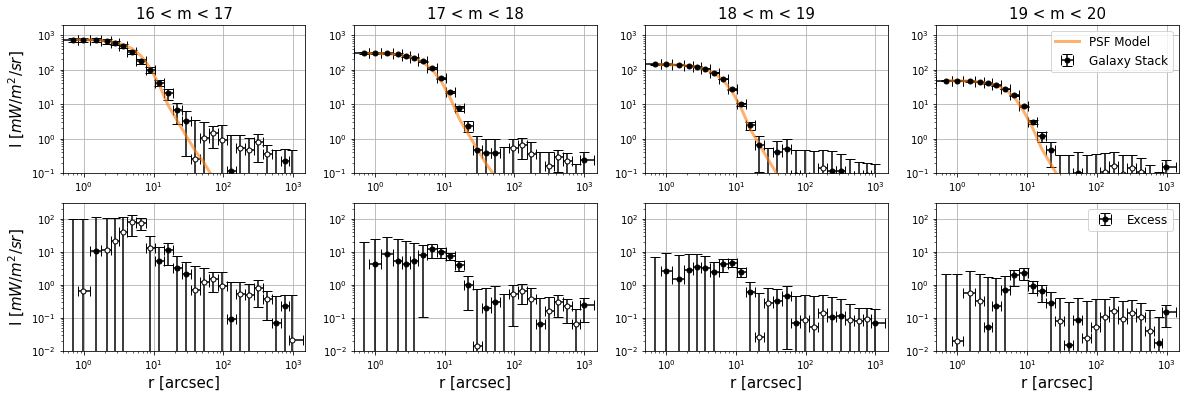

In [45]:
from stack import *

for ifield in [4,5,6,7,8]:
    for inst in [1,2]:
        plt.close()
        fig, ax = plt.subplots(2, 4, figsize = (20,6))
        filt_order = filt_order_dict[inst]
        for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
            stackdat = stacking(inst, ifield, m_min, m_max, filt_order=filt_order,
                                load_from_file=True, BGsub=False).stackdat

            plot_err_log(stackdat['rbins'], 
                         stackdat['profcb'],
                         np.sqrt(np.diag(stackdat['cov']['profcb'])),
                         ax=ax[0][im], color='k',label='Galaxy Stack')
            ax[0][im].loglog(stackdat['rbins'],stackdat['PSF']['profcb'],
                          'C1', alpha=0.6, lw=3, label='PSF Model')
#             plot_err_log(stackdat['rbins']*1.01, 
#                          stackdat['BG']['profcb'],
#                          np.sqrt(np.diag(stackdat['BGcov']['profcb'])),
#                          ax=ax[0][im], color='C0', label='Background Stack')
            ax[0][im].set_ylim([1e-1,2e3])
            ax[0][im].set_xlim([5e-1,1.5e3])
            ax[0][im].grid()    
            ax[0][im].set_title('%d < m < %d'%(m_min, m_max), fontsize=15)

            plot_err_log(stackdat['rbins'], 
                         stackdat['ex']['profcb'],
                         np.sqrt(np.diag(stackdat['excov']['profcb'])),
                         ax=ax[1][im], color='k',label='Excess')
            ax[1][im].set_ylim([1e-2,3e2])
            ax[1][im].set_xlim([5e-1,1.5e3])
            ax[1][im].grid()    
            ax[1][im].set_xlabel('r [arcsec]', fontsize=15)

        ax[0][0].set_ylabel('I [$mW/m^2/sr$]', fontsize=15)
        ax[1][0].set_ylabel('I [$mW/m^2/sr$]', fontsize=15)
        ax[0][-1].legend(fontsize=12)
        ax[1][-1].legend(fontsize=12)

        plt.savefig('plots/paperfig/profile_TM%d_%s.pdf'%(inst, fieldnamedict[ifield]),
                    dpi = 150, bbox_inches='tight')

#### field-averaged

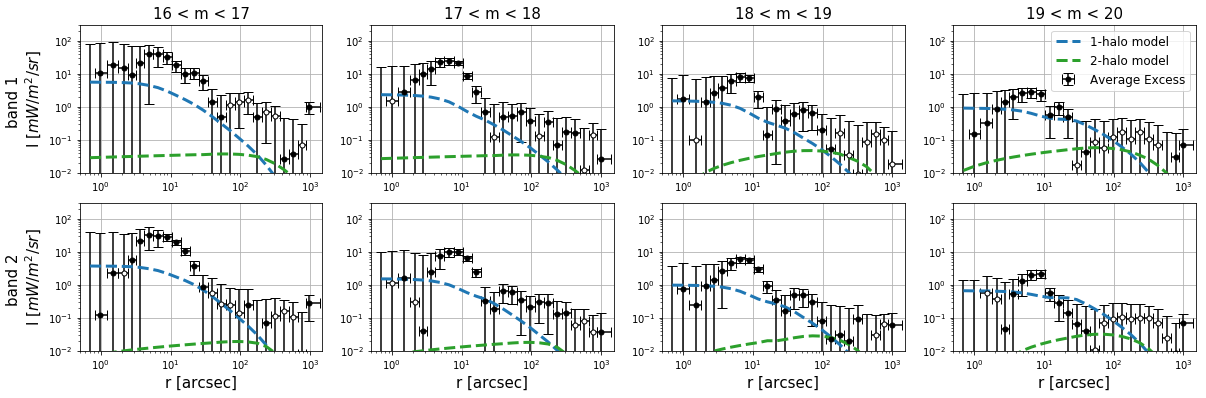

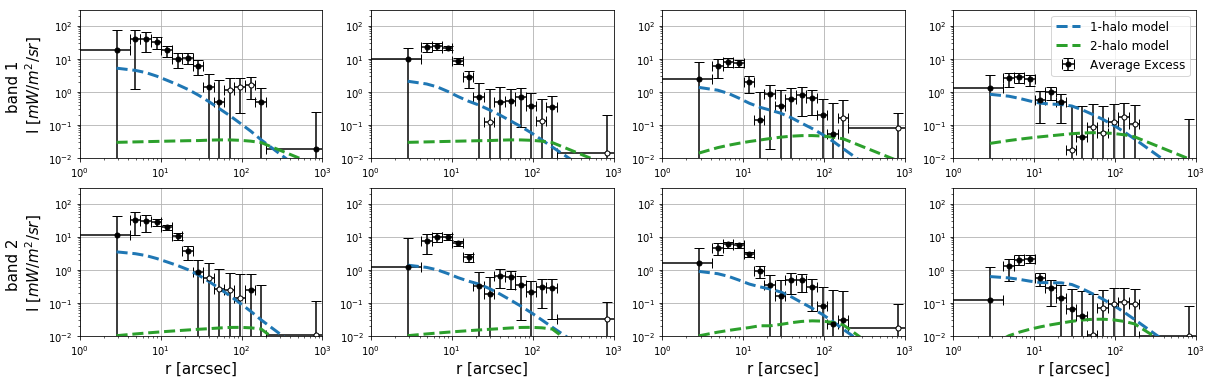

In [2]:
from stack import *
from micecat import *
from micecat_auto import *

fig1, ax1 = plt.subplots(2, 4, figsize = (20,6))
fig2, ax2 = plt.subplots(2, 4, figsize = (20,6))

for inst in [1,2]:
    filt_order = filt_order_dict[inst]
    for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
        profd_arr, profd_err = 0, 0
        profdsub_arr, profdsub_err = 0, 0
        for ifield in [4,5,6,7,8]:
            stackdat = stacking(inst, ifield, m_min, m_max, filt_order=filt_order,
                                load_from_file=True, BGsub=False).stackdat

            profd_arri = stackdat['ex']['profcb']
            profd_erri = np.sqrt(np.diag(stackdat['excov']['profcb']))
            profd_arr += profd_arri / profd_erri**2
            profd_err += 1 / profd_erri**2
            profdsub_arri = stackdat['ex']['profcbsub']
            profdsub_erri = np.sqrt(np.diag(stackdat['excov']['profcbsub']))
            profdsub_arr += profdsub_arri / profdsub_erri**2
            profdsub_err += 1 / profdsub_erri**2

        profd_arr /= profd_err
        profd_err = np.sqrt(1 / profd_err)
        profdsub_arr /= profdsub_err
        profdsub_err = np.sqrt(1 / profdsub_err)

        plot_err_log(stackdat['rbins'], 
                 profd_arr,profd_err,
                 ax=ax1[inst-1][im], color='k',label='Average Excess')
        plot_err_log(stackdat['rsubbins'], 
                 profdsub_arr,profdsub_err,
                 xedges = stackdat['rsubbinedges'],
                 ax=ax2[inst-1][im], color='k',label='Average Excess')
        
#         if inst==1: ###
        _, mc_1h, _, _ = get_micecat_sim_1h(inst, im, Mhcut=1e14, 
                                            R200cut=0, zcut=0.15, sub=False)
        _, mc_2h,  = micecat_profile_fit(inst, im, filt_order=filt_order,
                                         sub=False, return_full=False)

        ax1[inst-1][im].plot(stackdat['rbins'], mc_1h, 'C0--', lw=3, label='1-halo model')
        ax1[inst-1][im].plot(stackdat['rbins'], mc_2h, 'C2--', lw=3, label='2-halo model')

        _, mc_1h, _, _ = get_micecat_sim_1h(inst, im, Mhcut=1e14, 
                                            R200cut=0, zcut=0.15, sub=True)
        _, mc_2h,  = micecat_profile_fit(inst, im, filt_order=filt_order,
                                         sub=True, return_full=False)

        ax2[inst-1][im].plot(stackdat['rsubbins'], mc_1h, 'C0--', lw=3, label='1-halo model')
        ax2[inst-1][im].plot(stackdat['rsubbins'], mc_2h, 'C2--', lw=3, label='2-halo model')

        ax1[inst-1][im].set_ylim([1e-2,3e2])
        ax1[inst-1][im].set_xlim([5e-1,1.5e3])
        ax1[0][im].set_title('%d < m < %d'%(m_min, m_max), fontsize=15)
        ax1[inst-1][im].grid() 
        ax1[1][im].set_xlabel('r [arcsec]', fontsize=15)
        
        ax2[inst-1][im].set_ylim([1e-2,3e2])
        ax2[inst-1][im].set_xlim([1e0,1e3])
        ax2[inst-1][im].grid()    
        ax2[1][im].set_xlabel('r [arcsec]', fontsize=15)

    ax1[0][0].set_ylabel('band 1 \nI [$mW/m^2/sr$]', fontsize=15)
    ax2[0][0].set_ylabel('band 1 \nI [$mW/m^2/sr$]', fontsize=15)
    ax1[1][0].set_ylabel('band 2 \nI [$mW/m^2/sr$]', fontsize=15)
    ax2[1][0].set_ylabel('band 2 \nI [$mW/m^2/sr$]', fontsize=15)
    ax1[0][-1].legend(fontsize=12)
    ax2[0][-1].legend(fontsize=12)

    fig1.savefig('plots/paperfig/profile_avg.pdf',
                dpi = 150, bbox_inches='tight')

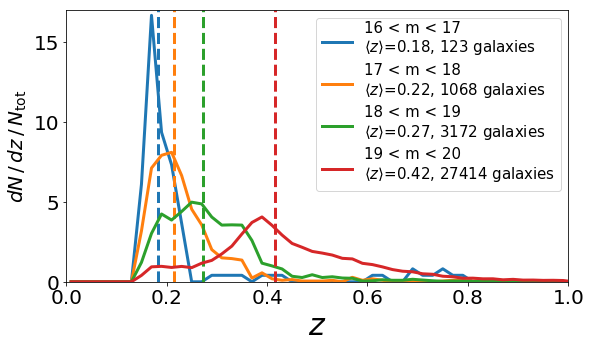

In [41]:
from astropy import units as u
from ciber_info import *
# from reduction import *
# data_maps = {1: image_reduction(1), 2: image_reduction(2)}

fig, ax = plt.subplots(1, 1, figsize = (9, 5))

dz = 0.02
binedges = np.arange(0,1.1,dz)
bins = (binedges[1:] + binedges[:-1]) / 2

htot = np.zeros([4, len(bins)],dtype=int)

mask_inst1, mask_inst2 = \
load_processed_images(data_maps, return_names=[(1,ifield,'mask_inst'),(2,ifield,'mask_inst')])

meanzs = {}
medianzs = {}
for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
    zs = np.array([])
    for i,ifield in enumerate([4,5,6,7,8]):
        field = fieldnamedict[ifield]
        srcdat = ps_src_select(1, ifield, m_min, m_max, 
            [mask_inst1, mask_inst2], sample_type='all')
        z = np.array(srcdat['zg_arr'])
        zs = np.concatenate((zs,z))

    meanzs[im] = np.mean(zs)
    medianzs[im] = np.median(zs)
    h,_ = np.histogram(zs, bins=binedges)
    htot[im,:] = h
        
for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
    meanz = meanzs[im]
    medianz = medianzs[im]
    ax.plot(bins, htot[im,:]/np.sum(htot[im,:])/dz, lw=3,  c='C'+str(im),
        label='%d < m < %d'%(m_min,m_max) + '\n'+  r'$\left< z \right>$=%.2f'%medianz \
            + ', %d galaxies'%np.sum(htot[im,:]))
    ax.axvline(medianz,c='C'+str(im),ls='--', lw=3)
ax.set_xlabel('$z$', fontsize=30)
ax.set_ylabel(r'$dN\,/\,dz\,/\,N_{\rm tot}$', fontsize=20)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.legend(fontsize=15)
ax.set_ylim([0,17])
ax.set_xlim([0,1])
plt.savefig('plots/z_kernel.pdf', dpi = 100, bbox_inches='tight')

## Stacked Source Distribution

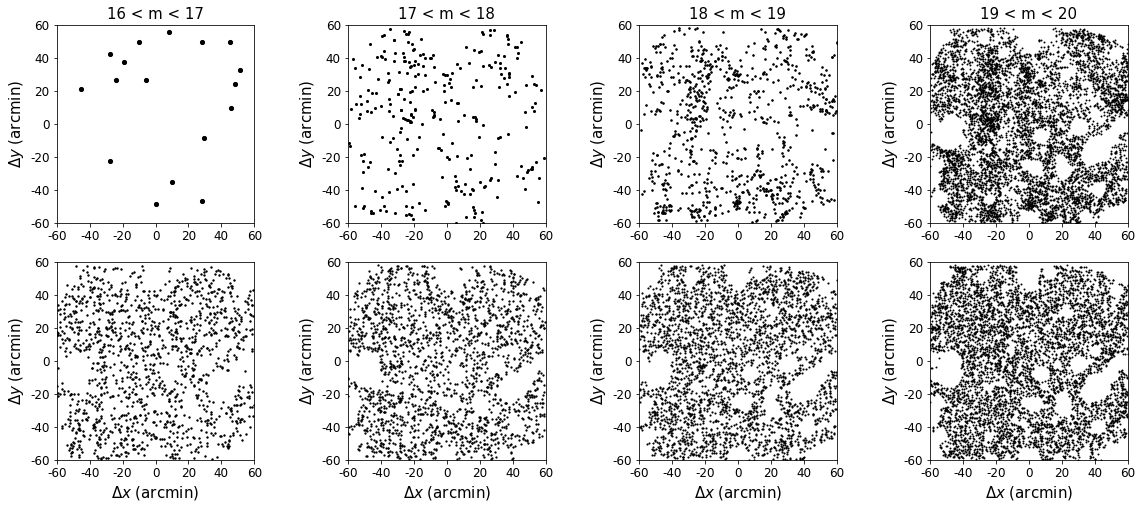

In [38]:
from stack_ancillary import *
# from reduction import *
# data_maps = {1: image_reduction(1), 2: image_reduction(2)}

pixticks = np.linspace(0,1023,7)
pixtick_labels = ['-60', '-40', '-20', '0', '20', '40', '60']

inst = 1
for ifield in [4,5,6,7,8]:
    cbmap, psmap, strmask, strnum, mask_inst1, mask_inst2 = \
    load_processed_images(data_maps, return_names=[(inst,ifield,'cbmap'), 
                                        (inst,ifield,'psmap'),
                                       (inst,ifield,'strmask'), 
                                       (inst,ifield,'strnum'),
                                       (1,ifield,'mask_inst'),
                               (2,ifield,'mask_inst')])
    if inst==1:
        mask_inst = mask_inst1
    else:
        mask_inst = mask_inst2

    plt.close()
    fig, ax = plt.subplots(2, 4, figsize = (20,8))
    for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
        srcdat = ps_src_select(inst, ifield, m_min, m_max, 
            [mask_inst1, mask_inst2], sample_type='all')
        xg, yg = srcdat['xg_arr'], srcdat['yg_arr']
        xs, ys = srcdat['xs_arr'], srcdat['ys_arr']
        
        ax[0][im].scatter(xg, yg, s=np.sqrt(5e3/len(xg)), c='k')
        ax[0][im].set_title('%d < m < %d'%(m_min, m_max), fontsize=15)
        ax[0][im].set_xlim([0,1023])
        ax[0][im].set_ylim([0,1023])
        ax[0][im].set_aspect('equal')   
        ax[0][im].set_xticks(pixticks)
        ax[0][im].set_xticklabels(pixtick_labels, fontsize=12)
        ax[0][im].set_yticks(pixticks)
        ax[0][im].set_yticklabels(pixtick_labels, fontsize=12)
        ax[0][im].set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)
        
        ax[1][im].scatter(xs, ys, s=np.sqrt(5e3/len(xs)), c='k')
        ax[1][im].set_xlim([0,1023])
        ax[1][im].set_ylim([0,1023])
        ax[1][im].set_aspect('equal')   
        ax[1][im].set_xticks(pixticks)
        ax[1][im].set_xticklabels(pixtick_labels, fontsize=12)
        ax[1][im].set_xlabel(r"$\Delta x$ (arcmin)", fontsize=15)
        ax[1][im].set_yticks(pixticks)
        ax[1][im].set_yticklabels(pixtick_labels, fontsize=12)
        ax[1][im].set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)
    
    plt.savefig('plots/paperfig/gal_scatter_%s.pdf'%(fieldnamedict[ifield]),
                dpi = 50, bbox_inches='tight')

***

# Plot for MZ's Proposal

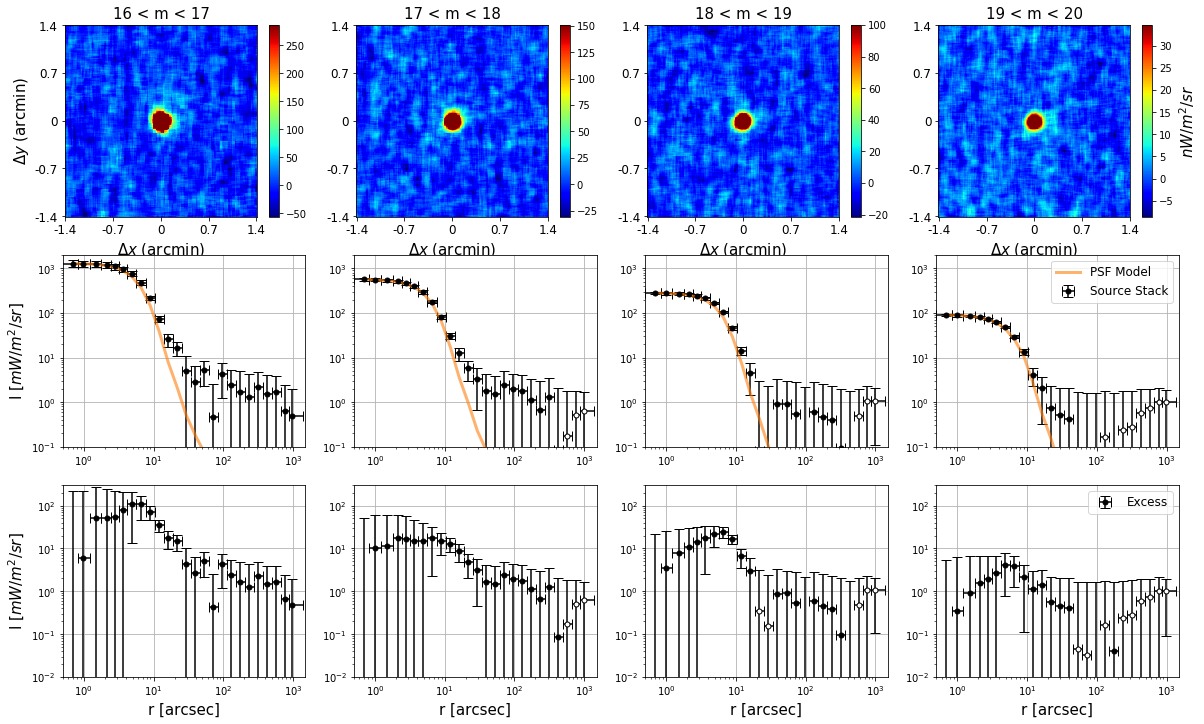

In [149]:
from stack import *

inst = 1
ifield = 6

fig, ax = plt.subplots(3, 4, figsize = (20,12))
for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
    stackdat = stacking(inst, ifield, m_min, m_max, load_from_file=True, BGsub=False).stackdat
    plot_err_log(stackdat['rbins'], 
                 stackdat['profcb'],
                 np.sqrt(np.diag(stackdat['cov']['profcb'])),
                 ax=ax[1][im], color='k',label='Source Stack')
    ax[1][im].loglog(stackdat['rbins'],stackdat['PSF']['profcb'],
                  'C1', alpha=0.6, lw=3, label='PSF Model')
    ax[1][im].set_ylim([1e-1,2e3])
    ax[1][im].set_xlim([5e-1,1.5e3])
    ax[1][im].grid()    

    plot_err_log(stackdat['rbins'], 
                 stackdat['ex']['profcb'],
                 np.sqrt(np.diag(stackdat['excov']['profcb'])),
                 ax=ax[2][im], color='k',label='Excess')
    ax[2][im].set_ylim([1e-2,3e2])
    ax[2][im].set_xlim([5e-1,1.5e3])
    ax[2][im].grid()    
    ax[2][im].set_xlabel('r [arcsec]', fontsize=15)

    axi = ax[0][im]
    p = imageclip(stackdat['cbmapstack'], ax=axi, return_objects=True)
    p['cbar'].remove()
    vmin, vmax = p['vmin'], p['vmax']
    stackmap = stackdat['cbmapstack'][1080:1321, 1080:1321]
    pixticks1 = np.linspace(0,240,5)
    pixtick_labels1 = ['-1.4', '-0.7', '0', '0.7', '1.4']
    p = imageclip(stackmap, ax=axi, return_objects=True, vmin=vmin, vmax=vmax*5)
    if im==3:
        p['cbar'].ax.set_ylabel('$nW/m^2/sr$', rotation=90, fontsize=15)
    axi.set_xticks(pixticks1)
    axi.set_xticklabels(pixtick_labels1, fontsize=12)
    axi.set_yticks(pixticks1)
    axi.set_yticklabels(pixtick_labels1, fontsize=12)
    axi.set_xlabel(r"$\Delta x$ (arcmin)", fontsize=15)
    if im==0:
        axi.set_ylabel(r"$\Delta y$ (arcmin)", fontsize=15)
    axi.set_title('%d < m < %d'%(m_min, m_max), fontsize=15)

ax[1][0].set_ylabel('I [$mW/m^2/sr$]', fontsize=15)
ax[2][0].set_ylabel('I [$mW/m^2/sr$]', fontsize=15)
ax[1][-1].legend(fontsize=12)
ax[2][-1].legend(fontsize=12)

plt.savefig('/Users/sers/ytcheng/ciber/doc/MZ_TM%d_%s.pdf'%(inst, fieldnamedict[ifield]),
            dpi = 200, bbox_inches='tight')